In [237]:
# Exercise 1.5
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import scipy.stats as st



In [ ]:
S = 2000
n = 300
B = 500
mean = [0,0,0]
cov = [[1,0.2,-0.6],[0.2,4,0.6],[-0.6,0.6,9]]
phi = [[0 for i in range(S)] for j in range(5)]

In [ ]:
for s in range(S):
    print(s)
    X = np.random.multivariate_normal(mean, cov, n)
    # phi[0]
    estimator = sum(X)/len(X)
    phi[0][s] = min(estimator)

    # phi[1]
    temp = 0
    for b in range(B):
        W_star = np.random.uniform(0,1,n)
        X_star = random.choices(X,weights=W_star,k=n)
        temp += min(sum(X_star)/len(X_star))
    phi[1][s] = 2* phi[0][s] - temp / B

    # phi[2]
    temp = 0
    for b in range(B):
        V = np.random.multivariate_normal([0,0,0], [[10,0,0],[0,10,0],[0,0,10]], 1)[0]
        temp += min( estimator + V/math.sqrt(n) )
    phi[2][s] = temp / B

    # phi[3]
    temp1 = 0
    temp2 = 0
    for i in range(3):
        temp1 += estimator[i] * math.exp(-math.sqrt(n) * estimator[i])
        temp2 += math.exp(-math.sqrt(n) * estimator[i])
    phi[3][s] = temp1 / temp2

    # phi[4]
    X1 = X[0:int(0.2*n)]
    X2 = X[int(0.2*n):len(X)]
    estimator1 = sum(X1) / len(X1)
    k = np.argmin(estimator1)
    estimator2 = sum(X2) / len(X2)
    phi[4][s] = estimator2[k]

In [ ]:
h_begin = -5
h_end = 5
step_size = 0.05
step_num = int((h_end - h_begin) / step_size) + 1

h_all = [0 for i in range(step_num)]
bias_all = [[0 for i in range(step_num)] for j in range(5)]
risk_all = [[0 for i in range(step_num)] for j in range(5)]

for i in range(step_num):
    h = h_begin + i * step_size
    h_all[i] = h
    print("h=",h)
    current = min( np.array([0,h,2*h])/math.sqrt(n) )
    for j in range(5):
        bias_temp = 0
        risk_temp = 0
        for s in range(S):
            temp = phi[j][s] - current
            bias_temp = bias_temp + temp
            risk_temp = risk_temp + math.pow(temp,2)
        bias_temp /= S
        risk_temp /= S
        bias_all[j][i] = bias_temp
        risk_all[j][i] = risk_temp


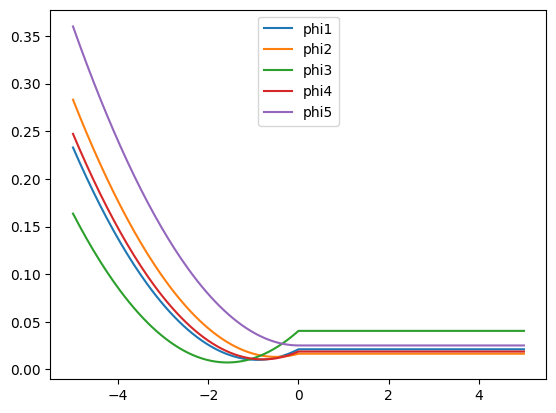

In [ ]:
plt.plot(h_all, risk_all[0],label="phi1")
plt.plot(h_all, risk_all[1],label="phi2")
plt.plot(h_all, risk_all[2],label="phi3")
plt.plot(h_all, risk_all[3],label="phi4")
plt.plot(h_all, risk_all[4],label="phi5")
leg = plt.legend(loc='upper center')
plt.show()

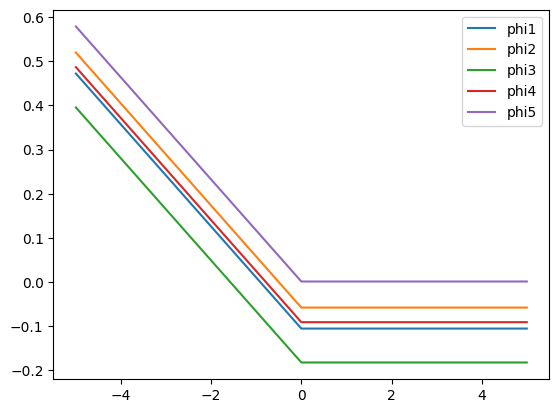

In [ ]:
plt.plot(h_all, bias_all[0],label="phi1")
plt.plot(h_all, bias_all[1],label="phi2")
plt.plot(h_all, bias_all[2],label="phi3")
plt.plot(h_all, bias_all[3],label="phi4")
plt.plot(h_all, bias_all[4],label="phi5")
leg = plt.legend()
plt.show()

In [ ]:
# Exercise 1.2

# Fang and Santos
alpha = 0.05
all_test = [0 for i in range(B)]
X = np.random.multivariate_normal(mean, cov, n)
X_mean = sum(X)/len(X)

temp = 0
for b in range(B):
    W_star = np.random.uniform(0,1,n)
    X_star = random.choices(X,weights=W_star,k=n)
    temp = (sum(X_star)/len(X_star))
    all_test[b] = min(math.sqrt(n) * (temp - X_mean) )
Fang = np.quantile(all_test, (1-alpha))/math.sqrt(n)

In [249]:
# Chernozhukov, Lee, and Rosen
temp_matrix = [[0 for i in range(3)] for j in range(3)]
for k in range(n):
    for i in range(3):
        for j in range(3):
            temp_matrix[i][j] += (X[k] - X_mean)[i] * (X[k] - X_mean)[j] / n

X_var_sqrt = sqrtm(temp_matrix)
para = 1 - 0.1 / math.log(n)
all_k = [0 for i in range(B)]
temp_p = [[1,0,0],
          [0,1,0],
          [0,0,1]
           ]
all_Z = [0 for i in range(B)]
for b in range(B):
    Z = np.random.multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]], 1)[0]
    all_Z[b] = Z
    temp_k_v = [0 for i in range(3)]
    for i in range(3):
        g = np.matmul(temp_p[i],X_var_sqrt)
        temp_k_v[i] = np.matmul(g,Z)/np.linalg.norm(g)
    all_k[b] = max(temp_k_v)

final_k = np.quantile(all_k, para)
V_index = []
temp = [0 for i in range(3)]
for i in range(3):
    g = np.matmul(temp_p[i],X_var_sqrt)
    s = np.linalg.norm(g) / math.sqrt(n)
    temp[i] = X_mean[i] + final_k * s
final_rhs = min(temp)

for i in range(3):
    g = np.matmul(temp_p[i],X_var_sqrt)
    s = np.linalg.norm(g) / math.sqrt(n)
    if (X_mean[i] -2*final_k* s) <= final_rhs:
        V_index.append(i)

all_k = [0 for i in range(B)]
for b in range(B):
    temp_k_v = [0 for i in V_index]
    for i in V_index:
        g = np.matmul(temp_p[i],X_var_sqrt)
        temp_k_v[i] = np.matmul(g,Z)/np.linalg.norm(g)
    all_k[b] = max(temp_k_v)
final_k = np.quantile(all_k, (1-alpha))

temp = [0 for i in range(3)]
for i in range(3):
    g = np.matmul(temp_p[i],X_var_sqrt)
    temp[i] = X_mean[i] + final_k * np.linalg.norm(g) / math.sqrt(n)

Cher = min(temp)


In [252]:
# sample splitting
X1 = X[0:int(0.2*n)]
X2 = X[int(0.2*n):len(X)]
estimator1 = sum(X1) / len(X1)
k = np.argmin(estimator1)
X2_mean = sum(X2)/len(X2)
temp_matrix = [[0 for i in range(3)] for j in range(3)]
for m in range(int(0.8*n)):
    for i in range(3):
        for j in range(3):
            temp_matrix[i][j] += (X2[m] - X2_mean)[i] * (X2[m] - X2_mean)[j] / (0.8*n)
split = X2_mean[k] + st.norm.ppf(1-alpha) * temp_matrix[k][k] / math.sqrt(0.8*n)


In [254]:
print(Fang, Cher, split)

0.03384883440639442 0.03651456081888137 0.3578802078877217
